# Plan-and-Execute

In [3]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

In [5]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

os.environ.get('OPENAI_API_KEY')

print("API Key Loaded", os.environ.get('OPENAI_API_KEY') is not None)

API Key Loaded True


### Define Tools

### Currency Converter

In [191]:
import requests
from langchain.tools import StructuredTool
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel, Field

def convert_currency(amount: float, from_currency: str, to_currency: str) -> float:
    """
    This function is used to transfer currency amount from one currency to another
    """ 
    url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
    response = requests.get(url)
    data = response.json()
    rate = data['rates'][to_currency]
    converted_amount = amount * rate
    return round(converted_amount, 2)

class CurrencyConversionInput(BaseModel):
    amount: float = Field(..., description="The amount of money to convert")
    from_currency: str = Field(..., description="The currency to convert from (e.g., USD)")
    to_currency: str = Field(..., description="The currency to convert to (e.g., EUR)")

currency_conversion_tool = StructuredTool.from_function(
    name="currency_converter",
    description="Convert an amount from one currency to another",
    func=convert_currency,
    args_schema=CurrencyConversionInput
)

In [137]:
convert_currency(100, "USD", "EUR")

89.7

### Get Weather

In [193]:
from datetime import datetime, timedelta
import requests
def get_weather(location: str, days_ahead: int = 0) -> str:
    """
    This function uses the OpenWeatherMap API to get the current weather for a given location.
    """ 

    api_key = os.environ.get("OPENWEATHERMAP_API_KEY")
    if not api_key:
        raise Exception("OPENWEATHERMAP_API_KEY environment variable not set.")

    if days_ahead > 0:
        target_date = (datetime.now() + timedelta(days=days_ahead)).strftime('%Y-%m-%d')
    else:
        target_date = None

    base_url = "http://api.openweathermap.org/data/2.5/weather"  

    params = {
        "q": location,
        "appid": api_key,
        "units": "metric"
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
=        if target_date:
            return f"The weather in {data['name']}, {data['sys']['country']} on {target_date} is currently {data['weather'][0]['description']} with a temperature of {data['main']['temp']}°C. The humidity is {data['main']['humidity']}% and the wind speed is {data['wind']['speed']} m/s."
        else:
            return f"The weather in {data['name']}, {data['sys']['country']} is currently {data['weather'][0]['description']} with a temperature of {data['main']['temp']}°C. The humidity is {data['main']['humidity']}% and the wind speed is {data['wind']['speed']} m/s."
    else:
        raise Exception(f"Error fetching weather data: {response.status_code}")

class WeatherInput(BaseModel):
    location: str = Field(..., description="The city and country to get weather for")
    days_ahead: int = Field(0, description="Number of days ahead for forecast (0 for current weather)")

weather_tool = StructuredTool.from_function(
    name="weather_forecast",
    description="Get the weather forecast for a specific location and date",
    func=get_weather,
    args_schema=WeatherInput
)

In [179]:
get_weather('dubai',3)

'The weather in Dubai, AE on 2024-09-23 is currently clear sky with a temperature of 33.77°C. The humidity is 59% and the wind speed is 3.6 m/s.'

### Language Translation

In [197]:
from transformers import pipeline

def translate_text(text, target_language):
    """
    This function is used to provide translation from any other language to english.
    """
    try:
        translator = pipeline("translation", model="facebook/m2m100_418M")
        translation = translator(text, src_lang="en", tgt_lang=target_language)[0]['translation_text']
        return translation
    except Exception as e:
        print(f"An error occurred during translation: {e}")
        return "Translation failed."

class TranslationInput(BaseModel):
    text: str = Field(..., description="The text to translate")
    target_language: str = Field(..., description="The target language code (e.g., 'fr' for French, 'es' for Spanish)")

translation_tool = StructuredTool.from_function(
    name="language_translator",
    description="Translate text from English to a specified target language",
    func=translate_text,
    args_schema=TranslationInput
)

In [184]:
translate_text("hi how are you", "fr")

'Bonjour comment vous êtes'

### Tavily Search

In [201]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Create the TavilySearch tool
tavily_search = TavilySearchResults(max_results=2)

# Combine the tools into a list
tools = [tavily_search, currency_conversion_tool, weather_tool, translation_tool]

### Define our Execution Agent

In [204]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_core.messages import SystemMessage, HumanMessage

# Define a custom prompt template
custom_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content="You are a helpful AI assistant for travel planning."),
    MessagesPlaceholder(variable_name="messages"),
    HumanMessage(content="{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

# Create the agent
agent = create_openai_functions_agent(llm, tools, custom_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

/opt/anaconda3/lib/python3.11/site-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


### Define the State

In [207]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### Planning Step

In [210]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [212]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [214]:
planner.invoke(
    {
        "messages": [
            ("user", "I am planning to go to dubai next month with a budget of $2000. Can you please help me plan my trip by providing information about the weather, currency converter, and sample language translation?")
        ]
    }
)

Plan(steps=['Check the weather forecast for Dubai for the next month.', 'Find the current exchange rate from USD to AED (United Arab Emirates Dirham).', 'Translate common English phrases to Arabic.'])

### Re-Plan Step

In [216]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """
    For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
    
    Your objective was this:
    {input}
    
    Your original plan was this:
    {plan}
    
    You have currently done the follow steps:
    {past_steps}
    
    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. 
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.
    """
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

### Create the Graph

In [282]:
import re
from typing import Dict, Any, List, Literal, Union
from pydantic import BaseModel, Field

def format_final_response(state: Dict[str, Any]) -> str:
    weather_info = ""
    currency_info = ""
    greeting = ""
    directions = []
    budget = 2000  

    for step in state.get("past_steps", []):
        if "weather forecast" in step[0].lower():
            weather_info = step[1]
        elif "exchange rate" in step[0].lower():
            currency_info = step[1]
        elif "common greetings" in step[0].lower():
            greeting = step[1].split('"')[1] if '"' in step[1] else ""
        elif "asking directions" in step[0].lower():
            directions = [line.strip() for line in step[1].split('\n') if line.startswith('-')]

   
    temp_match = re.search(r'(\d+)°C', weather_info)
    temperature = temp_match.group(1) if temp_match else "N/A"

    formatted_response = f"""
For your 5-day trip to Dubai next month, here's what you should prepare:

1. **Weather**: {weather_info}
   It's crucial to stay hydrated and wear light, breathable clothing. Don't forget sunscreen and a hat, as the sun can be intense.

2. **Language**: While many people in Dubai speak English, knowing some basic Arabic phrases can enhance your experience. Here are some useful translations:
   Greeting: {greeting}
   
   Directions:
   {chr(10).join(directions)}

3. **Budget Considerations**: With a budget of ${budget}, plan for accommodations, meals, transportation, and activities. {currency_info}
   Dubai can be quite luxurious, so consider exploring a mix of high-end and budget-friendly options.

If you need help with specific activity recommendations that fit your budget, feel free to ask!
"""
    return formatted_response.strip()


async def execute_step(state: PlanExecute):
    plan = state.get("plan", [])
    if not plan:
        # All tasks completed, format the final response
        final_response = format_final_response(state)
        return {
            "response": final_response
        }
    
    task = plan[0]
    task_formatted = f"For the following plan: {', '.join(plan)}\n\nYou are tasked with executing step: {task}"

    agent_response = await agent_executor.ainvoke(
        {
            "input": task_formatted,
            "messages": [("user", task_formatted)],
            "agent_scratchpad": [],
        }
    )
    
    return {
        "past_steps": [(task, agent_response["output"])]
    }


async def replan_step(state: PlanExecute) -> Dict[str, Any]:
    if not state.get("plan"):
        return {"response": "All tasks completed. Your trip planning is finished."}

    output = await replanner.ainvoke(state)
    
    if isinstance(output, Act):
        if output.Steps:
            return {"plan": output.Steps}
        elif isinstance(output.action, dict) and 'Steps' in output.action:
            return {"plan": output.action['Steps']}
    elif isinstance(output, dict) and 'Steps' in output:
        return {"plan": output['Steps']}
    
    # If we can't parse the output or if the plan is empty, assume all tasks are completed
    return {"response": "All tasks completed. Your trip planning is finished."}

class Plan(BaseModel):
    steps: List[str] = Field(..., description="Steps of the plan")

class Response(BaseModel):
    response: str = Field(..., description="Response to the user")

from pydantic import BaseModel, Field, root_validator
from typing import Union, List, Dict, Any, Optional

class Act(BaseModel):
    action: Optional[Union[Dict[str, List[str]], List[str]]] = Field(None, description="Action to perform")
    Steps: Optional[List[str]] = Field(None, description="Steps of the plan")

    @root_validator(pre=True)
    def check_structure(cls, values):
        if 'Steps' in values and 'action' not in values:
            values['action'] = {'Steps': values['Steps']}
        return values

    class Config:
        extra = 'allow'

def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"



from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser

replanner_prompt = ChatPromptTemplate.from_template(
    """
    For the given objective, come up with a simple step by step plan. \
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
    
    Your objective was this:
    {input}
    
    Your original plan was this:
    {plan}
    
    You have currently done the follow steps:
    {past_steps}
    
    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. 
    Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.
    
    Your response should be in the following format:
    {{"Steps": ["Step 1", "Step 2", "Step 3"]}}
    """
)

output_parser = PydanticOutputParser(pydantic_object=Act)

replanner = replanner_prompt | ChatOpenAI(model="gpt-4o", temperature=0) | output_parser

/var/folders/gq/6gkq7lc97m7gd82nff7t_xn80000gp/T/ipykernel_82266/3802728987.py:101: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @root_validator(pre=True)


In [284]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
)

app = workflow.compile()

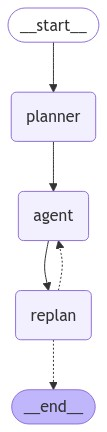

In [286]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [288]:
config = {"recursion_limit": 54}
inputs = {"input": "I am planning to go to dubai next month with a budget of $2000. Can you please help me plan my trip by providing information about the weather, currency converter, and sample language translation for greetings and asking directions?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


{'plan': ['Check the weather forecast for Dubai for the next month.', 'Find the current exchange rate from USD to AED (United Arab Emirates Dirham).', 'Translate common greetings from English to Arabic.', 'Translate common phrases for asking directions from English to Arabic.']}

Invoking: `weather_forecast` with `{'location': 'Dubai, United Arab Emirates', 'days_ahead': 30}`


The weather in Dubai, AE on 2024-10-20 is currently clear sky with a temperature of 33°C. The humidity is 66% and the wind speed is 2.57 m/s.The weather forecast for Dubai, United Arab Emirates, for the next month, specifically on 2024-10-20, indicates clear skies with a temperature of 33°C. The humidity will be around 66% and the wind speed will be 2.57 m/s.

> Finished chain.
{'past_steps': [('Check the weather forecast for Dubai for the next month.', 'The weather forecast for Dubai, United Arab Emirates, for the next month, specifically on 2024-10-20, indicates clear skies with a temperature of 33°C. The humi

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


{'plan': ['Find the current exchange rate from USD to AED (United Arab Emirates Dirham).', 'Translate common greetings from English to Arabic.', 'Translate common phrases for asking directions from English to Arabic.']}

Invoking: `currency_converter` with `{'amount': 1, 'from_currency': 'USD', 'to_currency': 'AED'}`


3.67The current exchange rate from USD to AED (United Arab Emirates Dirham) is 1 USD = 3.67 AED.

> Finished chain.
{'past_steps': [('Find the current exchange rate from USD to AED (United Arab Emirates Dirham).', 'The current exchange rate from USD to AED (United Arab Emirates Dirham) is 1 USD = 3.67 AED.')]}


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


{'plan': ['Translate common greetings from English to Arabic.', 'Translate common phrases for asking directions from English to Arabic.']}

Invoking: `language_translator` with `{'text': 'Hello', 'target_language': 'ar'}`


مرحبا
Invoking: `language_translator` with `{'text': 'Good morning', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good evening', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good evening', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good evening', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good evening', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good evening', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good evening', 'target_language': 'ar'}`


صباح الخير
Invoking: `language_translator` with `{'text': 'Good bye

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


{'plan': ['Translate common phrases for asking directions from English to Arabic.']}

Invoking: `language_translator` with `{'text': 'How do I get to the nearest subway station?', 'target_language': 'ar'}`


كيف يمكنني الوصول إلى أقرب محطة مترو الأنفاق؟
Invoking: `language_translator` with `{'text': 'Where is the nearest bathroom?', 'target_language': 'ar'}`


أين أقرب حمام؟
Invoking: `language_translator` with `{'text': 'Can you show me the way to the airport?', 'target_language': 'ar'}`


هل يمكنك أن تظهر لي الطريق إلى المطار؟
Invoking: `language_translator` with `{'text': 'Is there a restaurant nearby?', 'target_language': 'ar'}`


هل يوجد مطعم قريب؟Here are the translations of the common phrases for asking directions from English to Arabic:

- "How do I get to the nearest subway station?" translates to "كيف يمكنني الوصول إلى أقرب محطة مترو الأنفاق؟"
- "Where is the nearest bathroom?" translates to "أين أقرب حمام؟"
- "Can you show me the way to the airport?" translates to "هل يمكنك 